In [2]:
import numpy
from scipy.constants import c as light_speed
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from matplotlib import rc
import healpy
rcParams['mathtext.default'] = 'regular'

In [3]:
def jones_matrix_short_dipole(theta, phi):
    jones_matrix = numpy.zeros((theta.shape)+ (2,2), dtype=complex)
    
    jones_matrix[...,0,0] = numpy.cos(theta)*numpy.sin(phi)
    jones_matrix[...,0,1] = numpy.cos(phi)
    jones_matrix[...,1,0] = numpy.cos(theta)*numpy.cos(phi)
    jones_matrix[...,1,1] = -numpy.sin(theta)
    
    return jones_matrix

In [4]:
def cross_dipole(theta):
    response = numpy.cos(theta)
    return response

In [5]:
def gaussian_response(theta,target_theta = 0, theta_width = 30./180*numpy.pi):
    response = 1./numpy.sqrt(2.*numpy.pi*theta_width**2.)*numpy.exp(-0.5*(theta-target_theta)**2./theta_width**2.)
    return response

In [6]:
def electric_field_ground_plane(theta, frequency=150e6 , height= 0.3):
    wavelength = light_speed/frequency
    ground_plane_electric_field = numpy.sin(2.*numpy.pi*height/wavelength*numpy.cos(theta))
    return ground_plane_electric_field

In [7]:
def get_array_factor(x,y,z, weights ,theta, phi,  theta_pointing = 0, phi_pointing = 0, frequency=150e6):
    wavelength = light_speed/frequency
    number_dipoles= len(x)
    k_x = (2.*numpy.pi/wavelength)*numpy.sin(theta)*numpy.sin(phi)
    k_y = (2.*numpy.pi/wavelength)*numpy.sin(theta)*numpy.cos(phi)
    k_z = (2.*numpy.pi/wavelength)*numpy.cos(theta)
    
    k_x0 = (2.*numpy.pi/wavelength)*numpy.sin(theta_pointing)*numpy.sin(phi_pointing) 
    k_y0 = (2.*numpy.pi/wavelength)*numpy.sin(theta_pointing)*numpy.cos(phi_pointing)
    k_z0 = (2.*numpy.pi/wavelength)*numpy.cos(theta_pointing)
    array_factor_map = numpy.zeros(theta.shape, dtype=complex)
    for i in range(number_dipoles):
        array_factor_map += weights[i]*numpy.exp(1.j*((k_x - k_x0)*x[i] + (k_y - k_y0)*y[i] + (k_z - k_z0)*z[i]))
    
    
    return array_factor_map/sum(weights)    

In [8]:
def tile_array_response(theta, phi,target_theta=0, target_phi=0,  frequency=150e6, weights = 1):
    dipole_sep = 0.8  # meters
    x_offsets = numpy.array([-1.5,-0.5,0.5,1.5,-1.5,-0.5,0.5,1.5,-1.5,
                             -0.5,0.5,1.5,-1.5,-0.5,0.5,1.5],dtype=numpy.float32)*dipole_sep
    y_offsets = numpy.array([1.5,1.5,1.5,1.5,0.5,0.5,0.5,0.5,-0.5,-0.5,
                             -0.5,-0.5,-1.5,-1.5,-1.5,-1.5],dtype=numpy.float32)*dipole_sep 
    z_offsets = numpy.zeros(x_offsets.shape)
   
    weights += numpy.zeros(x_offsets.shape) 
    
    dipole_jones_matrix = jones_matrix_short_dipole(theta, phi)
    ground_plane_field = electric_field_ground_plane(theta, frequency)
    
    array_factor = get_array_factor(x_offsets, y_offsets, z_offsets, weights, theta, phi, target_theta, target_phi,
                                    frequency)
    
    tile_response = numpy.zeros(dipole_jones_matrix.shape, dtype = complex)
    tile_response[...,0, 0] = array_factor*ground_plane_field*dipole_jones_matrix[...,0,0]
    tile_response[...,0, 1] = array_factor*ground_plane_field*dipole_jones_matrix[...,0,1]
    tile_response[...,1, 0] = array_factor*ground_plane_field*dipole_jones_matrix[...,1,0]
    tile_response[...,1, 1] = array_factor*ground_plane_field*dipole_jones_matrix[...,1,1]
    
    return tile_response

In [9]:
def mwa_tile_response(theta, phi,target_theta=0, target_phi=0,  frequency=150e6, weights_xx = 1, weights_yy = 1):

    tt, pp = numpy.meshgrid(theta, phi)
    tile_response_XX = tile_array_response(tt, pp, target_theta=target_theta, target_phi = target_phi, frequency=frequency, weights=weights_xx)
    tile_response_YY = tile_array_response(tt, pp + numpy.pi/2., target_theta=target_theta, target_phi = target_phi, frequency=frequency, weights=weights_yy)
    tile_response = (tile_response_XX + tile_response_YY)/numpy.sqrt(2.)
    return tile_response

In [10]:
def simple_mwa_tile(theta, phi,target_theta=0, target_phi=0,  frequency=150e6, weights=1, dipole_type = 'cross', 
                    theta_width=30/180*numpy.pi):
    dipole_sep = 1.1    # meters
    x_offsets = numpy.array([-1.5,-0.5,0.5,1.5,-1.5,-0.5,0.5,1.5,-1.5,
                             -0.5,0.5,1.5,-1.5,-0.5,0.5,1.5],dtype=numpy.float32)*dipole_sep
    y_offsets = numpy.array([1.5,1.5,1.5,1.5,0.5,0.5,0.5,0.5,-0.5,-0.5,
                             -0.5,-0.5,-1.5,-1.5,-1.5,-1.5],dtype=numpy.float32)*dipole_sep 
    z_offsets = numpy.zeros(x_offsets.shape)
    
    weights += numpy.zeros(x_offsets.shape) 
    
    if dipole_type == 'cross':
        dipole_jones_matrix = cross_dipole(theta)
    elif dipole_type == 'gaussian':
        print(theta_width)
        dipole_jones_matrix = gaussian_response(theta, theta_width)
    else:
        print("Wrong dipole_type: select cross or gaussian")

    ground_plane_field = electric_field_ground_plane(theta, frequency)
    
    array_factor = get_array_factor(x_offsets, y_offsets, z_offsets, weights, theta, phi, target_theta, target_phi,
                                    frequency)
    
    tile_response = numpy.zeros(dipole_jones_matrix.shape, dtype = complex)
    tile_response = array_factor*ground_plane_field*dipole_jones_matrix
    
    return tile_response
    
    

In [11]:
def healpy_plotting(tt, pp, tile_response):
    nside =32
    n_pixels = healpy.nside2npix(nside)
    
    indices = healpy.ang2pix(nside, tt.flatten(), pp.flatten())
    healpixmap = numpy.zeros((n_pixels), dtype=complex)

    healpixmap[indices] += tile_response.flatten()

    healpy.orthview(numpy.abs(healpixmap), rot =[0,90,0], half_sky=True, norm='none')
    healpy.graticule()

### Calculate Jones Matrix Short Dipole

In [27]:
theta = numpy.linspace(0,numpy.pi/2.,50)
phi = numpy.linspace(0, 2.*numpy.pi,200)

tt, pp = numpy.meshgrid(theta, phi)

dipole_response = jones_matrix_short_dipole(tt, pp)

/home/rjoseph/Software/anaconda2/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


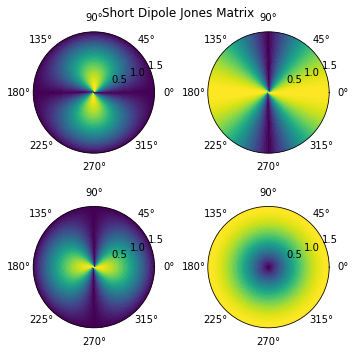

In [28]:
fig = pyplot.figure(figsize = (5,5))
pol_xx = fig.add_subplot(221, polar=True)
pol_xy = fig.add_subplot(222, polar=True)
pol_yx = fig.add_subplot(223, polar=True)
pol_yy = fig.add_subplot(224, polar=True)

pol_xx.pcolormesh(pp,tt, numpy.abs(dipole_response[...,0,0]))
pol_xy.pcolormesh(pp,tt, numpy.abs(dipole_response[...,0,1]))
pol_yx.pcolormesh(pp,tt, numpy.abs(dipole_response[...,1,0]))
pol_yy.pcolormesh(pp,tt, numpy.abs(dipole_response[...,1,1]))
fig.suptitle("Short Dipole Jones Matrix")
pyplot.show()

### Calculate Ground Screen Reponse

In [29]:
theta = numpy.linspace(0,numpy.pi/2.,50)
phi = numpy.linspace(0, 2.*numpy.pi,200)

tt, pp = numpy.meshgrid(theta, phi)

ground_response = electric_field_ground_plane(tt)


/home/rjoseph/Software/anaconda2/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


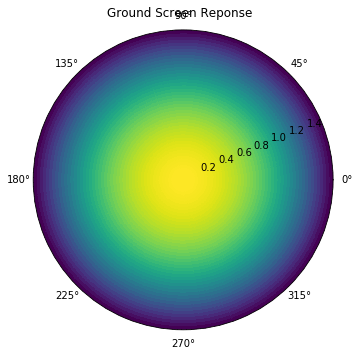

In [30]:
fig = pyplot.figure(figsize = (5,5))
pol_xx = fig.add_subplot(111, polar=True)
pol_xx.pcolormesh(pp,tt, numpy.abs(ground_response))

fig.suptitle("Ground Screen Reponse")
pyplot.show()

### Calculate Response Dipole + Ground Screen

In [31]:
mwa_dipole_response = numpy.zeros(dipole_response.shape, dtype=complex) 
mwa_dipole_response[...,0,0] = dipole_response[...,1,0]*ground_response
mwa_dipole_response[...,0,1] = dipole_response[...,0,1]*ground_response
mwa_dipole_response[...,1,0] = dipole_response[...,1,0]*ground_response
mwa_dipole_response[...,1,1] = dipole_response[...,1,1]*ground_response

/home/rjoseph/Software/anaconda2/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


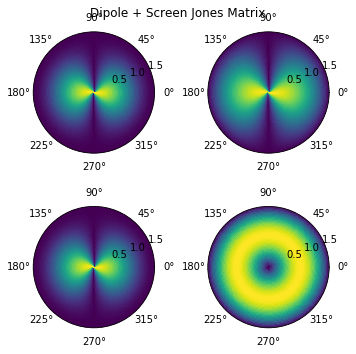

In [32]:
fig = pyplot.figure(figsize = (5,5))
pol_xx = fig.add_subplot(221, polar=True)
pol_xy = fig.add_subplot(222, polar=True)
pol_yx = fig.add_subplot(223, polar=True)
pol_yy = fig.add_subplot(224, polar=True)

pol_xx.pcolormesh(pp,tt, numpy.abs(mwa_dipole_response[...,0,0]))
pol_xy.pcolormesh(pp,tt, numpy.abs(mwa_dipole_response[...,0,1]))
pol_yx.pcolormesh(pp,tt, numpy.abs(mwa_dipole_response[...,1,0]))
pol_yy.pcolormesh(pp,tt, numpy.abs(mwa_dipole_response[...,1,1]))
fig.suptitle("Dipole + Screen Jones Matrix")
pyplot.show()

### Calculate Array Factor Map

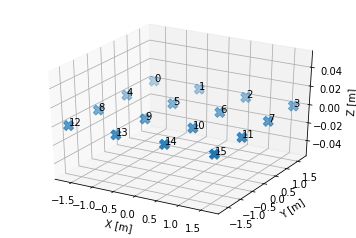

In [18]:
target_theta = 0
target_phi = 0

theta = numpy.linspace(0,numpy.pi/2.,512)
phi = numpy.linspace(0, 2.*numpy.pi,512)


dipole_sep = 1.1    # meters
x_offsets = numpy.array([-1.5,-0.5,0.5,1.5,-1.5,-0.5,0.5,1.5,-1.5,
                             -0.5,0.5,1.5,-1.5,-0.5,0.5,1.5],dtype=numpy.float32)*dipole_sep
y_offsets = numpy.array([1.5,1.5,1.5,1.5,0.5,0.5,0.5,0.5,-0.5,-0.5,
                             -0.5,-0.5,-1.5,-1.5,-1.5,-1.5],dtype=numpy.float32)*dipole_sep 
z_offsets = numpy.zeros(x_offsets.shape)

fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_offsets, y_offsets, z_offsets, marker = "X", s = 100)
for i in range(len(x_offsets)):
    ax.text(x_offsets[i], y_offsets[i], z_offsets[i], str(i))
    
weights = numpy.zeros(x_offsets.shape) + 1

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

tt, pp = numpy.meshgrid(theta, phi)
array_factor = get_array_factor(x_offsets, y_offsets, z_offsets, weights, tt, pp, target_theta, target_phi)


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]
/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/healpy/projector.py:750: RuntimeWarning: invalid value encountered in greater
  mask = (np.asarray(x)**2+np.asarray(y)**2>1.0)


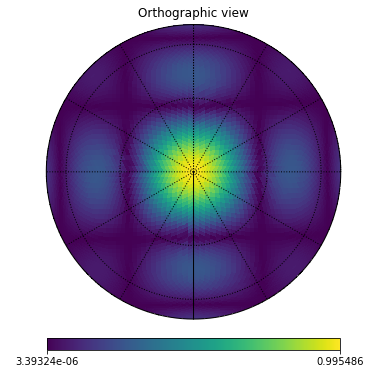

In [27]:
healpy_plotting(tt, pp, array_factor)

#fig = pyplot.figure(figsize = (5,5))
#pol_xx = fig.add_subplot(111, polar=True)


#pol_xx.pcolormesh(pp,tt, numpy.abs(array_factor))
#fig.suptitle("Array Factor")
#pyplot.show()

### Calculate Response Phase Array ( Short Dipole x Ground Screen x Array Factor)

In [1]:
target_theta = 0
target_phi = 0
theta = numpy.linspace(0,numpy.pi/2.,50)
phi = numpy.linspace(0, 2.*numpy.pi,200)

tt, pp = numpy.meshgrid(theta, phi)
tile_response = tile_array_response(tt, pp, frequency=150e6, target_theta=target_theta, target_phi=target_phi)

NameError: name 'numpy' is not defined

In [2]:
fig = pyplot.figure(figsize = (5,5))
pol_xx = fig.add_subplot(221, polar=True)
pol_xy = fig.add_subplot(222, polar=True)
pol_yx = fig.add_subplot(223, polar=True)
pol_yy = fig.add_subplot(224, polar=True)

pol_xx.pcolormesh(pp,tt, numpy.abs(tile_response[...,0,0]))
pol_xy.pcolormesh(pp,tt, numpy.abs(tile_response[...,0,1]))
pol_yx.pcolormesh(pp,tt, numpy.abs(tile_response[...,1,0]))
pol_yy.pcolormesh(pp,tt, numpy.abs(tile_response[...,1,1]))
fig.suptitle("MWA Tile")
pyplot.show()

NameError: name 'pyplot' is not defined

## Simple MWA Tile approach (omni-cross dipole/gaussian beam)

In [12]:
target_theta = 0
target_phi = 0

theta = numpy.linspace(0,numpy.pi/2.,100)
phi = numpy.linspace(0, 2.*numpy.pi,5000)
frequency = 150e6

dipole_type = "gaussian"
dipole_fov = 35/180*numpy.pi
weights_xx = numpy.zeros(16) + 1 
weights_xx[15] = 1
tt, pp = numpy.meshgrid(theta, phi)
tile_response = simple_mwa_tile(tt, pp, target_theta=target_theta, target_phi=target_phi, 
                                 frequency=150e6, weights = weights_xx, dipole_type = dipole_type, 
                                theta_width = dipole_fov)

0.0


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/ronniyjoseph/Software/anaconda2/lib/python2.7/site-packages/healpy/projaxes.py:416: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]
/home/ronniyjoseph/Software/anaconda2/lib/python2.7/site-packages/healpy/projector.py:846: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > 1.0


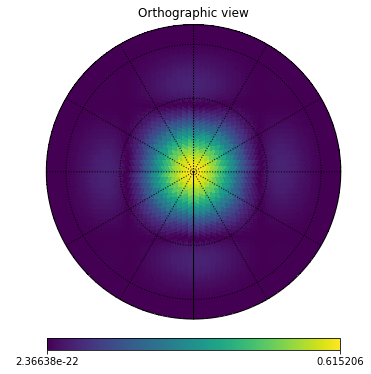

In [13]:
healpy_plotting(tt, pp, tile_response)

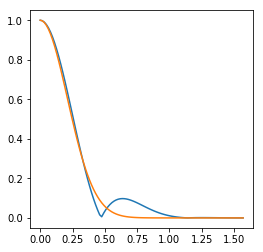

In [23]:
figure = pyplot.figure(figsize=(4,4))
compare_plot = figure.add_subplot(111)
compare_plot.plot(tt[0,:],numpy.abs(tile_response[0,:])/tile_response[0,0])


sigma = 0.42*2/4
#approximate gaussian response
approximation = gaussian_response(tt[0,:], theta_width = sigma )
compare_plot.plot(tt[0,:],approximation/max(approximation))


### Let's calculate a single slice, for different tile realisations

In [20]:
def tile_realisation(theta, phi, n_realisations):

    jones_matrix = numpy.zeros((theta.shape[0]*phi.shape[0],)+(n_realisations,2,2), dtype=complex)
    deviations = jones_matrix.copy()
    model_response = mwa_tile_response(theta, phi,target_theta=0, target_phi=0,  
                                           frequency=150e6)
    
    for i in range(n_realisations):
        #One or two polarizations?
        number_dead_dipoles = numpy.random.randint(0,3,1)
        dipole_indices = numpy.random.randint(0,31,number_dead_dipoles)
        
        weights = numpy.zeros(32) + 1
        weights[dipole_indices] = 0
        
        weights_xx = weights[0:16]
        weights_yy = weights[16:32]
        
        broken_tile_response =  mwa_tile_response(theta, phi, target_theta=0, target_phi=0,  
                                           frequency=150e6, weights_xx =weights_xx, weights_yy = weights_yy)

        jones_matrix[:,i,0,0] = broken_tile_response[...,0,0].flatten()
        jones_matrix[:,i,0,1] = broken_tile_response[...,0,1].flatten()
        jones_matrix[:,i,1,0] = broken_tile_response[...,1,0].flatten()
        jones_matrix[:,i,1,1] = broken_tile_response[...,1,1].flatten()
        

        deviations[:,i,0,0] = jones_matrix[:,i,0,0] - model_response[...,0,0].flatten()
        deviations[:,i,0,1] = jones_matrix[:,i,0,1] - model_response[...,0,1].flatten()
        deviations[:,i,1,0] = jones_matrix[:,i,1,0] - model_response[...,1,0].flatten()
        deviations[:,i,1,1] = jones_matrix[:,i,1,1] - model_response[...,1,1].flatten()
        
    
    return jones_matrix, deviations



In [21]:
number_realisations = 1000
phi = numpy.array([numpy.pi/3.])
theta = numpy.linspace(-numpy.pi/2.,numpy.pi/2.,50)
zenith_angle = numpy.degrees(theta)
jones_realisations, model_deviations = tile_realisation(theta, phi, number_realisations)

jones_model = mwa_tile_response(theta, phi,target_theta=0, target_phi=0,  
                                           frequency=150e6)



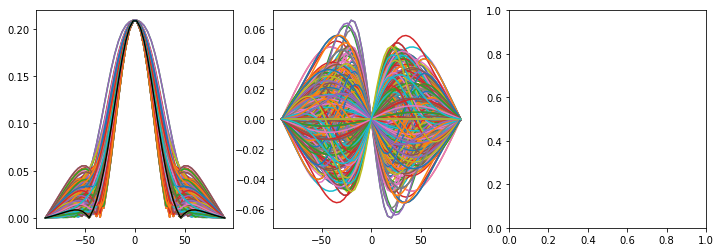

In [22]:
dev_figure = pyplot.figure(figsize=(12,4))
beam_sub = dev_figure.add_subplot(131)
dev_sub = dev_figure.add_subplot(132)
functional_dev_sub = dev_figure.add_subplot(133)


beam_sub.plot(zenith_angle, numpy.abs(jones_realisations[...,:,0,1]))
beam_sub.plot(zenith_angle, numpy.abs(jones_model[0,:,0,1]),'k')

dev_sub.plot(zenith_angle, numpy.imag(model_deviations[...,:,0,1]))


#amp =  numpy.max(numpy.mean())
#functional_dev_subb.plot(zenith_angle, numpy.real(model_deviations[...,:,0,1]))

dev_figure.savefig("beam_realisation.png")
pyplot.show()

In [16]:
Cov_B_zenith_xx = numpy.cov(jones_realisations[...,0,0])
Cov_B_zenith_xy = numpy.cov(jones_realisations[...,0,1])
Cov_B_zenith_yx = numpy.cov(jones_realisations[...,1,0])
Cov_B_zenith_yy = numpy.cov(jones_realisations[...,1,1])

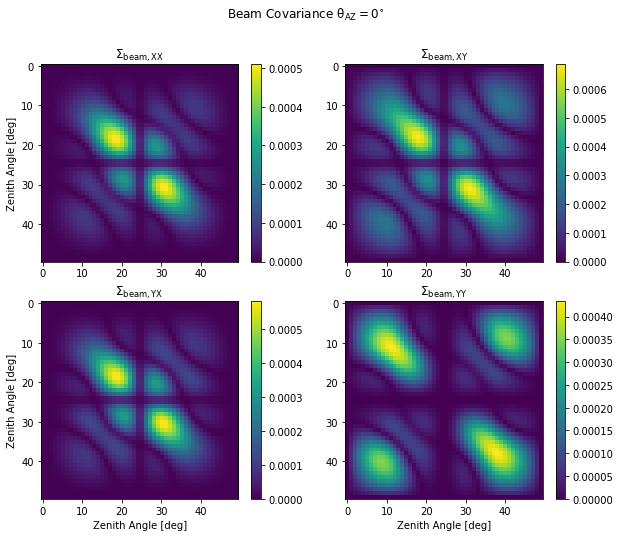

In [14]:
figure = pyplot.figure(figsize = (10,8))

cov_xx_sub = figure.add_subplot(221)
cov_xy_sub = figure.add_subplot(222)
cov_yx_sub = figure.add_subplot(223)
cov_yy_sub = figure.add_subplot(224)

cov_xx_plot = cov_xx_sub.imshow(numpy.abs(Cov_B_zenith_xx))
cov_xy_plot = cov_xy_sub.imshow(numpy.abs(Cov_B_zenith_xy))
cov_yx_plot = cov_yx_sub.imshow(numpy.abs(Cov_B_zenith_yx))
cov_yy_plot = cov_yy_sub.imshow(numpy.abs(Cov_B_zenith_yy))

#cov_xx_plot = cov_xx_sub.pcolor(zenith_angle,zenith_angle, numpy.abs(Cov_B_zenith_xx))
#cov_xy_plot = cov_xy_sub.pcolor(zenith_angle,zenith_angle, numpy.abs(Cov_B_zenith_xy))
#cov_yx_plot = cov_yx_sub.pcolor(zenith_angle,zenith_angle, numpy.abs(Cov_B_zenith_yx))
#cov_yy_plot = cov_yy_sub.pcolor(zenith_angle,zenith_angle, numpy.abs(Cov_B_zenith_yy))

cov_xx_sub.set_title(r"$\Sigma_{\mathrm{beam},XX}$")
cov_xy_sub.set_title(r"$\Sigma_{\mathrm{beam},XY}$")
cov_yx_sub.set_title(r"$\Sigma_{\mathrm{beam},YX}$")
cov_yy_sub.set_title(r"$\Sigma_{\mathrm{beam},YY}$")

cov_xx_sub.set_ylabel("Zenith Angle [deg]")
cov_yx_sub.set_ylabel("Zenith Angle [deg]")
cov_yx_sub.set_xlabel("Zenith Angle [deg]")
cov_yy_sub.set_xlabel("Zenith Angle [deg]")

pyplot.colorbar(cov_xx_plot,ax=cov_xx_sub)
pyplot.colorbar(cov_xy_plot,ax=cov_xy_sub)
pyplot.colorbar(cov_yx_plot,ax=cov_yx_sub)
pyplot.colorbar(cov_yy_plot,ax=cov_yy_sub)

figure.suptitle(r"Beam Covariance $\theta_{AZ} = 0^{\circ}$")
figure.savefig("beam_covariance.png")

### Full Sky Covariance Matrix

In [15]:
number_realisations = 1000
phi = numpy.linspace(0,2.*numpy.pi,50)
theta = numpy.linspace(-numpy.pi/2.,numpy.pi/2.,50)
zenith_angle = numpy.degrees(theta)
azimuth_angle= numpy.degrees(phi)
jones_realisations, model_deviations = tile_realisation(theta, phi, number_realisations)

jones_model = mwa_tile_response(theta, phi,target_theta=0, target_phi=0,  
                                           frequency=150e6)



In [16]:
Cov_B_zenith_xx = numpy.cov(jones_realisations[...,0,0])
Cov_B_zenith_xy = numpy.cov(jones_realisations[...,0,1])
Cov_B_zenith_yx = numpy.cov(jones_realisations[...,1,0])
Cov_B_zenith_yy = numpy.cov(jones_realisations[...,1,1])

<IPython.core.display.Javascript object>


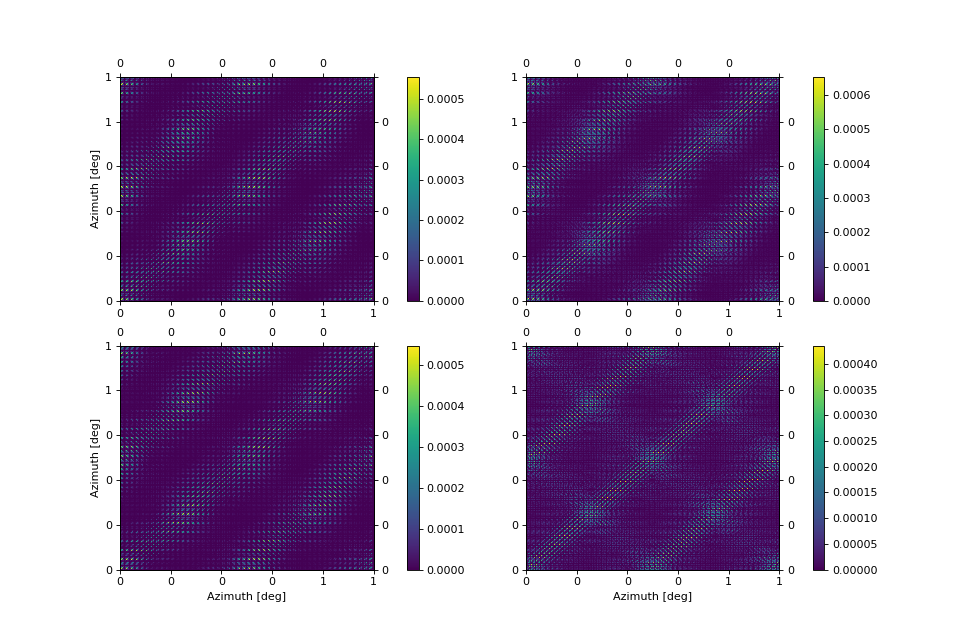

In [17]:
from matplotlib.ticker import FuncFormatter


%matplotlib notebook
figure = pyplot.figure(figsize = (12,8))

cov_xx_sub = figure.add_subplot(221)
cov_xy_sub = figure.add_subplot(222)
cov_yx_sub = figure.add_subplot(223)
cov_yy_sub = figure.add_subplot(224)




#cov_xx_plot = cov_xx_sub.imshow(numpy.abs(Cov_B_zenith_xx))
#cov_xy_plot = cov_xy_sub.imshow(numpy.abs(Cov_B_zenith_xy))
#cov_yx_plot = cov_yx_sub.imshow(numpy.abs(Cov_B_zenith_yx))
#cov_yy_plot = cov_yy_sub.imshow(numpy.abs(Cov_B_zenith_yy))

tt,pp = numpy.meshgrid(zenith_angle, azimuth_angle)

cov_xx_plot = cov_xx_sub.pcolormesh(numpy.abs(Cov_B_zenith_xx))
cov_xy_plot = cov_xy_sub.pcolormesh(numpy.abs(Cov_B_zenith_xy))
cov_yx_plot = cov_yx_sub.pcolormesh(numpy.abs(Cov_B_zenith_yx))
cov_yy_plot = cov_yy_sub.pcolormesh(numpy.abs(Cov_B_zenith_yy))

title_pad = -0.1
#cov_xx_sub.set_title(r"$\Sigma_{\mathrm{beam},XX}$", pad =title_pad )
#cov_xy_sub.set_title(r"$\Sigma_{\mathrm{beam},XY}$", pad =title_pad )
#cov_yx_sub.set_title(r"$\Sigma_{\mathrm{beam},YX}$", pad =title_pad )
#cov_yy_sub.set_title(r"$\Sigma_{\mathrm{beam},YY}$", pad =title_pad )

cov_xx_sub.set_ylabel("Azimuth [deg]")
cov_yx_sub.set_ylabel("Azimuth [deg]")
cov_yx_sub.set_xlabel("Azimuth [deg]")
cov_yy_sub.set_xlabel("Azimuth [deg]")

padding = 0.1
pyplot.colorbar(cov_xx_plot,ax=cov_xx_sub, pad=padding)
pyplot.colorbar(cov_xy_plot,ax=cov_xy_sub, pad=padding)
pyplot.colorbar(cov_yx_plot,ax=cov_yx_sub, pad=padding)
pyplot.colorbar(cov_yy_plot,ax=cov_yy_sub, pad=padding)


def format_az(tick_val, tick_pos):
    xs = numpy.arange(0,len(pp.flatten()))
    if int(tick_val) in xs:
        return int(pp.flatten()[xs == tick_val])
    else:
        return ''
    

def format_za(tick_val, tick_pos):
    xs = numpy.arange(0,len(tt.flatten()))
    scaled_tick = tick_val*len(tt.flatten())
    if int(scaled_tick) in xs:
        return int(tt.flatten()[xs == int(scaled_tick)])
    else:
        return ''
    
cov_xx_sub2x = cov_xx_sub.twinx()
cov_xy_sub2x = cov_xy_sub.twinx()
cov_yx_sub2x = cov_yx_sub.twinx()
cov_yy_sub2x = cov_yy_sub.twinx()
   
cov_xx_sub2y = cov_xx_sub.twiny()
cov_xy_sub2y = cov_xy_sub.twiny()
cov_yx_sub2y = cov_yx_sub.twiny()
cov_yy_sub2y = cov_yy_sub.twiny()
    
cov_xx_sub.xaxis.set_major_formatter(FuncFormatter(format_az))
cov_xy_sub.xaxis.set_major_formatter(FuncFormatter(format_az))
cov_yx_sub.xaxis.set_major_formatter(FuncFormatter(format_az))
cov_yy_sub.xaxis.set_major_formatter(FuncFormatter(format_az))

cov_xx_sub.yaxis.set_major_formatter(FuncFormatter(format_az))
cov_xy_sub.yaxis.set_major_formatter(FuncFormatter(format_az))
cov_yx_sub.yaxis.set_major_formatter(FuncFormatter(format_az))
cov_yy_sub.yaxis.set_major_formatter(FuncFormatter(format_az))


cov_xx_sub2x.yaxis.set_major_formatter(FuncFormatter(format_za))
cov_xy_sub2x.yaxis.set_major_formatter(FuncFormatter(format_za))
cov_yx_sub2x.yaxis.set_major_formatter(FuncFormatter(format_za))
cov_yy_sub2x.yaxis.set_major_formatter(FuncFormatter(format_za))

cov_xx_sub2y.xaxis.set_major_formatter(FuncFormatter(format_za))
cov_xy_sub2y.xaxis.set_major_formatter(FuncFormatter(format_za))
cov_yx_sub2y.xaxis.set_major_formatter(FuncFormatter(format_za))
cov_yy_sub2y.xaxis.set_major_formatter(FuncFormatter(format_za))



figure.savefig("fulsky_beam_covariance.png")

In [26]:
%matplotlib inline

In [15]:
a = range(4)

In [17]:
2 in numpy.arange(4)

True

In [24]:
(1+2+3+4+5)/5 + (6+7+8+9+10)/5

11

In [26]:
(1+2+3+4+5+6+7+8+9+10)/5

11